<a href="https://colab.research.google.com/github/hyunku/NLP-Basic/blob/main/9_%EA%B0%90%EC%A0%95%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.분석 준비

## 가.감정분석 방법론

사람의 정서적 상태와 주관적 정보를 체계적으로 식별, 추출하는 연구

* 로지스틱 회귀 방법에 의한 분석
* 딥러닝 방법에 의한 분석

## 나.한글폰트

In [ ]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()
# 여기까지 실행 후 "런타임 다시 시작..." 실행 (이 부분은 실행할 필요 없음)

## 다.환경설정

In [ ]:
# 형태소분석기
!pip install konlpy

In [ ]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data dir
data_dir = '/content/drive/MyDrive/Data/'
os.listdir(data_dir)

['kowiki',
 '감성대화',
 'sc_training.json',
 'sc_corpus.txt',
 'sc_training.csv',
 'corpus_mecab.txt',
 'GoogleNews-vectors-negative300.bin.gz',
 'w2v.model',
 'ko_vocab',
 'juso',
 'songys-chat',
 'downstream_exported',
 'myproject',
 'research.txt',
 'movie_comment.csv',
 'nsmc']

In [ ]:
nsrs_dir = os.path.join(data_dir, "myproject")
if not os.path.isdir(nsrs_dir):
    os.makedirs(nsrs_dir)
os.listdir(nsrs_dir)

['tripadviser_review.csv',
 'hotel.hdf5',
 'hotel.csv',
 'movie.hdf5',
 'movie.csv']

# 2.Data 준비 및 Preprocessing

## 가.Data

In [ ]:
!wget https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/tripadviser_review.csv

--2021-10-28 07:33:45--  https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/tripadviser_review.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 504648 (493K) [text/plain]
Saving to: ‘tripadviser_review.csv.1’

tripadviser_review. 100%[===================>] 492.82K  --.-KB/s    in 0.04s   

2021-10-28 07:33:46 (12.3 MB/s) - ‘tripadviser_review.csv.1’ saved [504648/504648]



In [ ]:
# Tripadvisor 여행사이트에서 "제주 호텔"로 검색해서 나온 리뷰들을 활용합니다. (평점 & 평가 내용 포함)
df = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/tripadviser_review.csv")
# 다운로드 자료 구글드라이브에 백업
df.to_csv(os.path.join(data_dir, 'myproject','tripadviser_review.csv'), index=False)

In [ ]:
# 구글드라이브 백업자료 불러와서 사용
df = pd.read_csv(os.path.join(data_dir, 'myproject','tripadviser_review.csv'), index_col=False)

In [ ]:
df.head()

,rating,text
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입..."
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...


In [ ]:
# 전체 데이터와 결측치 확인
print(df.shape)
# df.isnull().sum()
df.info()

(1001, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  1001 non-null   int64 
 1   text    1001 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


5    386
4    340
3    155
1     65
2     55
Name: rating, dtype: int64


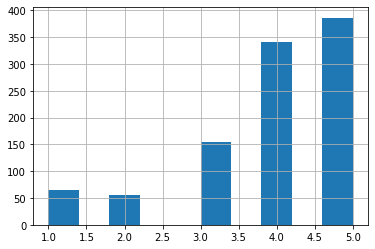

In [ ]:
# 점수별 현황
print(df['rating'].value_counts())
df['rating'].hist()

In [ ]:
# 점수를 기준으로 긍정(4,5)과 부정(1-3)으로 변환
def rating_to_label(rating):
    if rating > 3:
        return 1
    else:
        return 0

df['y'] = df['rating'].apply(lambda x: rating_to_label(x))

In [ ]:
# 긍정 및 부정평가 댓글 수
df["y"].value_counts()

1    726
0    275
Name: y, dtype: int64

## 나.한국어 텍스트 데이터 전처리

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  1001 non-null   int64 
 1   text    1001 non-null   object
 2   y       1001 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.6+ KB


In [ ]:
# 한글 불용어 사전 다운
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
# stopwords[:10]
# 형태 조정, 특별한 용어 추가 불용어
stopwords=[x[0]  for x in stopwords]
stopwords[:10]

['휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해']

In [ ]:
# stopwords 추가
jeju_hotel_stopwords = ['제주', '제주도', '호텔', '리뷰', '숙소', '여행', '트립']
for word in jeju_hotel_stopwords:
    stopwords.append(word)
print(stopwords)

['휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만', '하물며', '또한', '그러나', '그렇지만', '하지만', '이외에도', '대해 말하자면', '뿐이다', '다음에', '반대로', '반대로 말하자면', '이와 반대로', '바꾸어

In [ ]:
# df로 말뭉치로 만들면서 doc0은 부정, doc1은 긍정인 두개의 문서로 만듬
import konlpy
# tagger = konlpy.tag.Mecab()
tagger = konlpy.tag.Okt()

tokens=[]
corpus =[]
# stopwords = ['(,', '것', '계','간의']

for i, sentence in enumerate(df['text']):
    para = tagger.nouns(sentence)
    para = [x for x in para if x not in stopwords] # 불용어 제거
    para = [x for x in para if len(x) > 1]
    tokens.append(para)
    corpus.append(' '.join(para))

print(corpus[:5])
print(tokens[:5])


['집중 휴식 제공 위치 선정 청소 청결 상태', '침대 이불 침구 교체 어메니티 보강 베스트 웨스턴 회원 경우 객실 층수 요청 적극 반영', '지인 소개 처음 당황 세면 도구 잠옷 필수 그것', '정도 처음 박만', '저녁 맥주 한잔 렌트 뚜벅 버스 정류 도착 가방 일찍 정비 방이 입실 업그레이드 직원 정말']
[['집중', '휴식', '제공', '위치', '선정', '청소', '청결', '상태'], ['침대', '이불', '침구', '교체', '어메니티', '보강', '베스트', '웨스턴', '회원', '경우', '객실', '층수', '요청', '적극', '반영'], ['지인', '소개', '처음', '당황', '세면', '도구', '잠옷', '필수', '그것'], ['정도', '처음', '박만'], ['저녁', '맥주', '한잔', '렌트', '뚜벅', '버스', '정류', '도착', '가방', '일찍', '정비', '방이', '입실', '업그레이드', '직원', '정말']]


## 다.탐색적 데이터 분석(EDA)**

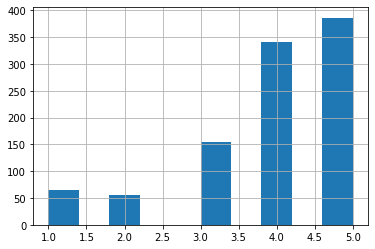

In [ ]:
# 점수별 빈도수
df['rating'].hist()

In [ ]:
# 긍정 평가와 부정평가 토큰을 분리하여 저장
print(df[:5])
print(df.loc[df['y']==0,][:5])
tokens_p, tokens_n = [],[]
for i, token in enumerate(tokens):
  # if i>5:
  #   break
  if df['y'].values[i]== 1:  # 주의 : df['y'][i] 값을 사용하면 기존 index가 참조되어서 값이 다름
    tokens_p.append(token)
  else :
    tokens_n.append(token)

print(tokens_p)
print(tokens_n)

   rating                                               text  y
0       4  여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...  1
1       4  2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입...  1
2       4  지인에소개로온 호텔  깨끗하고 좋은거같아요 처음에는 없는게 많아 많이  당황했는데 ...  1
3       5  방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...  1
4       5  저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...  1
    rating                                               text  y
5        1  바다전망이라해서 기대했는데 영아니네요.. 전일 함덕대명콘도에서 1박했는데 그곳이 실...  0
23       3  공항까지 택시10분 7000원미만의 택시비로 이동가능. 침구 및 룸상태 최상. 허나...  0
41       1  현재 호텔 묵고 있다 인터넷 예약할때 뷰지정할 수 없다고 돼있었는데 와보니 지정할수...  0
45       3  동문시장에 가서 식사나  쇼핑 등을 하려면 이 호텔을 이용하면 좋다. 관덕정 정문 ...  0
49       3  공항에서 10분정도의 대중교통으로 이동이 가능한곳으로 근처에 동문시장등 재래시장이 ...  0
[['집중', '휴식', '제공', '위치', '선정', '청소', '청결', '상태'], ['침대', '이불', '침구', '교체', '어메니티', '보강', '베스트', '웨스턴', '회원', '경우', '객실', '층수', '요청', '적극', '반영'], ['지인', '소개', '처음', '당황', '세면', '도구', '잠옷', '필수', '그것'], ['정도', '처음', '박만'], ['저

In [ ]:
# counter 함수에 넣기위한 전처리 : 토큰단위 리스트로
corpus_n, corpus_p = [], []
for token in tokens_p:
  corpus_p.append(' '.join(token))
for token in tokens_n:
  corpus_n.append(' '.join(token))
# 모든 리뷰를 긍정 부정 하나의 corpus로 합치기
corpus_p1 = ' '.join(corpus_p).split()
corpus_n1 = ' '.join(corpus_n).split()
print(corpus_p1)

['집중', '휴식', '제공', '위치', '선정', '청소', '청결', '상태', '침대', '이불', '침구', '교체', '어메니티', '보강', '베스트', '웨스턴', '회원', '경우', '객실', '층수', '요청', '적극', '반영', '지인', '소개', '처음', '당황', '세면', '도구', '잠옷', '필수', '그것', '정도', '처음', '박만', '저녁', '맥주', '한잔', '렌트', '뚜벅', '버스', '정류', '도착', '가방', '일찍', '정비', '방이', '입실', '업그레이드', '직원', '정말', '손님', '가장', '바다', '배치', '대해', '대응', '써비스', '조식', '부분', '신경', '아주', '특급', '트랜디', '대해', '고민', '흔적', '여름', '수영장', '사용', '보고', '엄마', '가격', '대비', '위치', '주위', '마트', '식당', '시장', '바다', '방문', '의사', '정해진', '휘슬', '처음', '공항', '생각', '시설', '직원', '친절', '모드', '마지막', '마무리', '테라스', '전경', '인근', '재래시장', '야시장', '이용도', '이용', '휘슬락', '체크', '주변', '여친', '추억', '가성', '분위기', '추천', '후회', '예전', '그랜드', '돌잔치', '다정', '했었더랬', '아주', '전통', '메종', '글래드', '업그레이드', '위치', '시설', '서비스', '매우', '합리', '가격', '대의', '명절', '글래드', '숙박', '아티', '백미', '커피', '베이커리', '가족', '플러스', '지금', '이용', '메종', '글래드', '가장', '공항', '접근성', '쇼핑', '조식', '만족도', '최고', '직원', '기억', '가족', '메종', '찾기', '엄마', '침구', '직원', '교통', '이틀', '정원', '거기', '수영장', '겨울', '여

In [ ]:
# 빈도 탐색
from collections import Counter
counter_p = Counter(corpus_p1)
counter_n = Counter(corpus_n1)
print(counter_p.most_common(10))
print(counter_n.most_common(10))

[('위치', 253), ('공항', 231), ('매우', 191), ('직원', 177), ('가격', 175), ('시설', 166), ('객실', 160), ('조식', 140), ('바다', 132), ('이용', 130)]
[('직원', 90), ('객실', 84), ('침대', 76), ('공항', 75), ('위치', 75), ('매우', 74), ('가격', 70), ('예약', 67), ('시설', 49), ('아침', 48)]


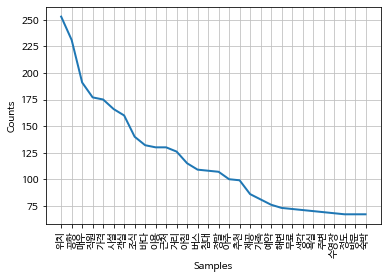

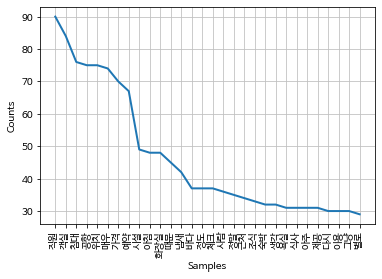

In [ ]:
# nltk 라이브러리 활용
import nltk
import matplotlib.pyplot as plt
pos = nltk.Text(corpus_p1)
neg = nltk.Text(corpus_n1)
plt.rc('font', family='NanumBarunGothic')

plt.figure(1)
pos.plot(30)

plt.figure(2)
neg.plot(30)
plt.show()

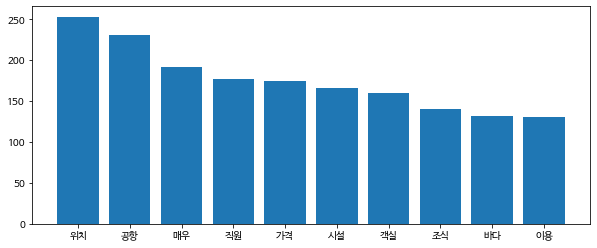

In [ ]:
top_10 = counter_p.most_common(10)

plt.figure(figsize=(10, 4))
plt.rc('font', family="NanumBarunGothic")
plt.rcParams["axes.unicode_minus"] = False # 한글 폰트 사용시 - 깨지는 문제 해결
plt.bar(range(len(top_10)), [val[1] for val in top_10])
plt.xticks(range(len(top_10)), [val[0] for val in top_10])
plt.show()

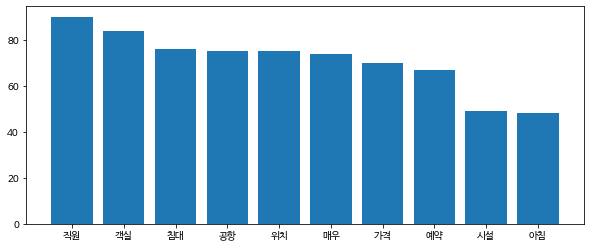

In [ ]:
top_10 = counter_n.most_common(10)

plt.figure(figsize=(10, 4))
plt.rc('font', family="NanumBarunGothic")
plt.rcParams["axes.unicode_minus"] = False # 한글 폰트 사용시 - 깨지는 문제 해결
plt.bar(range(len(top_10)), [val[1] for val in top_10])
plt.xticks(range(len(top_10)), [val[0] for val in top_10])
plt.show()

In [ ]:
# DTM 구하기, corpus 문서단위 * 단어사전 3482개 매트릭스
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import gensim
g_dictionary = gensim.corpora.Dictionary(tokens)
g_corpus = [g_dictionary.doc2bow(text) for text in tokens]
vector = CountVectorizer(vocabulary=g_dictionary.token2id)
dtm = vector.fit_transform(corpus).toarray()
col = g_dictionary.token2id.keys()
print(dtm.shape)
pd.DataFrame(dtm, columns=col)

(1001, 3482)


,상태,선정,위치,제공,집중,청결,청소,휴식,객실,경우,교체,반영,베스트,보강,어메니티,요청,웨스턴,이불,적극,층수,침구,침대,회원,그것,당황,도구,세면,소개,잠옷,지인,처음,필수,박만,정도,가방,도착,뚜벅,렌트,맥주,방이,...,불금,회수,침목,뒷골목,잔뜩,향수,가몬,교욱받,몬지,압니다,여행기,오피스텔,토요코인,장롱,혼란,훼손,구덩이,매듭,본질,북한,수치,역설,유인,진절머리,티슈,파멸,갱스터,논평,몸가짐,발언,사건,사람과,위협,재판,침묵,오른,악몽,퍼팅,규칙,더러
0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
999,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [ ]:
# TF-IDF 변환
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_vectorizer = TfidfTransformer()
tf_idf = tfidf_vectorizer.fit_transform(dtm).toarray()
col = g_dictionary.token2id.keys()
print(tf_idf.shape)
pd.DataFrame(tf_idf, columns=col)

(1001, 3482)


,상태,선정,위치,제공,집중,청결,청소,휴식,객실,경우,교체,반영,베스트,보강,어메니티,요청,웨스턴,이불,적극,층수,침구,침대,회원,그것,당황,도구,세면,소개,잠옷,지인,처음,필수,박만,정도,가방,도착,뚜벅,렌트,맥주,방이,...,불금,회수,침목,뒷골목,잔뜩,향수,가몬,교욱받,몬지,압니다,여행기,오피스텔,토요코인,장롱,혼란,훼손,구덩이,매듭,본질,북한,수치,역설,유인,진절머리,티슈,파멸,갱스터,논평,몸가짐,발언,사건,사람과,위협,재판,침묵,오른,악몽,퍼팅,규칙,더러
0,0.302641,0.504836,0.159395,0.237769,0.504836,0.331005,0.266906,0.36871,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.121768,0.191480,0.261317,0.323451,0.282382,0.323451,0.256038,0.206797,0.323451,0.239556,0.256038,0.323451,0.199182,0.133677,0.305278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.232560,0.335739,0.289041,0.280165,0.415569,0.415569,0.328956,0.252418,0.39222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.508209,0.00000,0.756327,0.411938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.314504,0.181593,0.314504,0.241991,0.230173,0.186418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.000000,0.000000,0.000000,0.226321,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000
997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.305068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

변환 후 1001*3482 matrix가 출력됩니다. 여기서

한 행(row)은 한 리뷰를 의미하고

한 열(column)은 한 단어를 의미합니다.


In [ ]:
# id_to_word
print(vector.vocabulary_)
id_to_word = {v: k for k, v in vector.vocabulary_.items()}
print(id_to_word)
print(id_to_word[10])

{'상태': 0, '선정': 1, '위치': 2, '제공': 3, '집중': 4, '청결': 5, '청소': 6, '휴식': 7, '객실': 8, '경우': 9, '교체': 10, '반영': 11, '베스트': 12, '보강': 13, '어메니티': 14, '요청': 15, '웨스턴': 16, '이불': 17, '적극': 18, '층수': 19, '침구': 20, '침대': 21, '회원': 22, '그것': 23, '당황': 24, '도구': 25, '세면': 26, '소개': 27, '잠옷': 28, '지인': 29, '처음': 30, '필수': 31, '박만': 32, '정도': 33, '가방': 34, '도착': 35, '뚜벅': 36, '렌트': 37, '맥주': 38, '방이': 39, '버스': 40, '업그레이드': 41, '일찍': 42, '입실': 43, '저녁': 44, '정류': 45, '정말': 46, '정비': 47, '직원': 48, '한잔': 49, '대명': 50, '바다': 51, '분위기': 52, '실내': 53, '전망': 54, '전일': 55, '콘도': 56, '함덕': 57, '가장': 58, '고민': 59, '대응': 60, '대해': 61, '배치': 62, '보고': 63, '부분': 64, '사용': 65, '손님': 66, '수영장': 67, '신경': 68, '써비스': 69, '아주': 70, '여름': 71, '조식': 72, '트랜디': 73, '특급': 74, '흔적': 75, '가격': 76, '대비': 77, '마트': 78, '방문': 79, '시장': 80, '식당': 81, '엄마': 82, '의사': 83, '주위': 84, '공항': 85, '마무리': 86, '마지막': 87, '모드': 88, '생각': 89, '시설': 90, '야시장': 91, '이용': 92, '이용도': 93, '인근': 94, '재래시장': 95, '전경': 96, '정해진': 97, '친절': 98, '

# 3.로지스틱 회귀에 의한 감정분석

## 가.데이터 준비

* 독립변수 X 는 tf_idf 행렬
* 종속변수 y 는 0 또는 1 인 벡터

In [ ]:
# 원천 데이터 데이터 프레임
df.head()

,rating,text,y
0,4,여행에 집중할수 있게 편안한 휴식을 제공하는 호텔이었습니다. 위치선정 또한 적당한 ...,1
1,4,"2일 이상 연박시 침대, 이불, 베게등 침구류 교체 및 어메니티 보강이 필요해 보입...",1
2,4,지인에소개로온 호텔 깨끗하고 좋은거같아요 처음에는 없는게 많아 많이 당황했는데 ...,1
3,5,방에 딱 들어서자마자 눈이 휘둥그레질정도로 이렇게 넓은 호텔 처음 와본 것 같아요!...,1
4,5,저녁에 맥주한잔 하는게 좋아서 렌트 안하고 뚜벅이 하기로 했는데 호텔 바로 앞에 버...,1


In [ ]:
# 긍정 및 부정평가 댓글 수
df["y"].value_counts()

1    726
0    275
Name: y, dtype: int64

### Train and Test Data 분리

In [ ]:
# data 로 종합 데이터 형성
X = tf_idf
y=df['y']
data = pd.concat([y,pd.DataFrame(X)], axis=1)
data

,y,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,3442,3443,3444,3445,3446,3447,3448,3449,3450,3451,3452,3453,3454,3455,3456,3457,3458,3459,3460,3461,3462,3463,3464,3465,3466,3467,3468,3469,3470,3471,3472,3473,3474,3475,3476,3477,3478,3479,3480,3481
0,1,0.302641,0.504836,0.159395,0.237769,0.504836,0.331005,0.266906,0.36871,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.121768,0.191480,0.261317,0.323451,0.282382,0.323451,0.256038,0.206797,0.323451,0.239556,0.256038,0.323451,0.199182,0.133677,0.305278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000
2,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.232560,0.335739,0.289041,0.280165,0.415569,0.415569,0.328956,0.252418,0.39222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000
3,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.508209,0.00000,0.756327,0.411938,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000
4,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.314504,0.181593,0.314504,0.241991,0.230173,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0,0.000000,0.000000,0.000000,0.226321,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000
997,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.305068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [ ]:
# 전체 데이터를 train 데이터 70%, test 데이터 30%로 분리
from sklearn.model_selection import train_test_split

train_df,test_df = train_test_split(data, test_size = 0.3, random_state=256)
train_df.head()

,y,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,3442,3443,3444,3445,3446,3447,3448,3449,3450,3451,3452,3453,3454,3455,3456,3457,3458,3459,3460,3461,3462,3463,3464,3465,3466,3467,3468,3469,3470,3471,3472,3473,3474,3475,3476,3477,3478,3479,3480,3481
558,1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0,0.0,0.0,0.000000,0.226321,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
459,0,0.0,0.0,0.157931,0.000000,0.0,0.0,0.0,0.0,0.188308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
336,1,0.0,0.0,0.129398,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142,1,0.0,0.0,0.116184,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.291285,0.0,0.0,0.0,0.181172,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 나.로지스틱 회귀분석

In [ ]:
# 데이터 설정 맞추기
x_train = train_df.drop(['y'], axis=1)
y_train = train_df['y']
x_test = test_df.drop(['y'], axis=1)
y_test = test_df['y']

In [ ]:
# 모델 학습
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# fit in training set
lr = LogisticRegression(random_state = 0)
lr.fit(x_train, y_train)

# predict in test set
y_pred = lr.predict(x_test)

In [ ]:
# classification result for test set
a1 = accuracy_score(y_test, y_pred)
p1 = precision_score(y_test, y_pred)
r1 =recall_score(y_test, y_pred)
f1= f1_score(y_test, y_pred)
print('accuracy: %.2f' % a1 )
print('precision: %.2f' % p1)
print('recall: %.2f' % r1)
print('F1: %.2f' % f1)

accuracy: 0.74
precision: 0.74
recall: 1.00
F1: 0.85


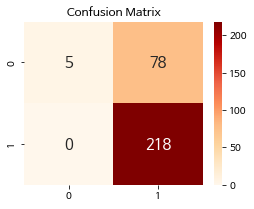

In [ ]:
# confusion matrix, 데이터 불균형에 의한 과적합

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = y_test, y_pred = y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#sampling 재조정
df['y'].value_counts()

1    726
0    275
Name: y, dtype: int64

In [ ]:
# under-sampling 방법으로 불균현 해소
positive_random_idx = df[df['y']==1].sample(275, random_state=12).index.tolist()
negative_random_idx = df[df['y']==0].sample(275, random_state=12).index.tolist()

In [ ]:
random_idx = positive_random_idx + negative_random_idx
x = tf_idf[random_idx]
y = df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

In [ ]:
x_train.shape, y_train.shape

((412, 3482), (412,))

In [ ]:
x_test.shape, y_test.shape

((138, 3482), (138,))

In [ ]:
lr2 = LogisticRegression(random_state = 0)
lr2.fit(x_train, y_train)
y_pred = lr2.predict(x_test)

In [ ]:
# classification result for test set
a2 = accuracy_score(y_test, y_pred)
p2 = precision_score(y_test, y_pred)
r2 =recall_score(y_test, y_pred)
f2= f1_score(y_test, y_pred)
print('accuracy: %.2f' % a2 )
print('precision: %.2f' % p2)
print('recall: %.2f' % r2)
print('F1: %.2f' % f2)

accuracy: 0.72
precision: 0.70
recall: 0.75
F1: 0.72


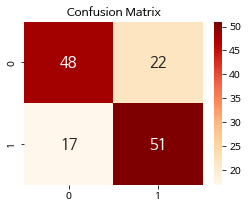

In [ ]:
# 개선된 confusion matrix

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = y_test, y_pred = y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 분류 정확도 test_result
pd.options.display.float_format = '{:.2f}'.format
tr1 = pd.DataFrame([a1,p1,r1,f1])
tr2 = pd.DataFrame([a2,p2,r2,f2])

test_result = pd.concat([tr1.T, tr2.T], axis=0)
test_result.columns=['Accuracy(정확도)', 'Precision(정밀도)', 'Recall(재현율)', 'F1']
test_result.index = ['1차 Imbalance Data', '2차 Under-sampling']
test_result



,Accuracy(정확도),Precision(정밀도),Recall(재현율),F1
1차 Imbalance Data,0.74,0.74,1.00,0.85
2차 Under-sampling,0.72,0.70,0.75,0.72


## 다.긍정 / 부정 키워드 분석

In [ ]:
# 긍정/부정 키워드 추출 긍 / 부정 키워드를 추출 coeficient를 시각화
lr2.coef_

array([[ 0.14027934,  0.22155082,  0.22649185, ..., -0.09597492,
        -0.05633916, -0.05633916]])

<BarContainer object of 3482 artists>

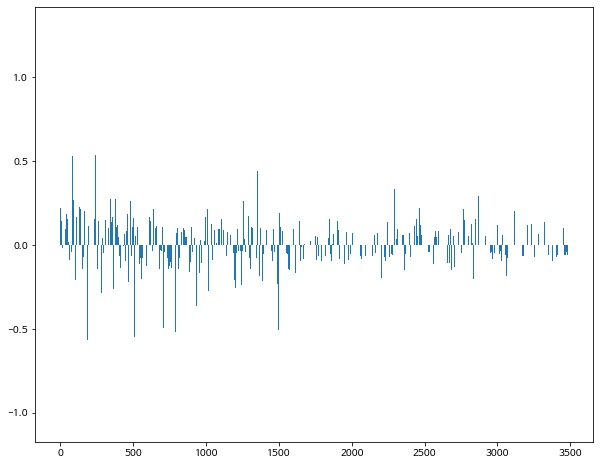

In [ ]:
# print logistic regression's coef

plt.figure(figsize=(10, 8))
plt.bar(range(len(lr2.coef_[0])), lr2.coef_[0])

In [ ]:
print(sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)[-5:])
# enumerate: 인덱스 번호와 컬렉션의 원소를 tuple형태로 반환함

[(1.3026965750036854, 79), (0.9314833030115539, 92), (0.9276902222490574, 51), (0.9145269921501282, 101), (0.9048726169559018, 72)]
[(-0.733064423721258, 416), (-0.7444487893471002, 513), (-0.8019233214826574, 21), (-0.9345863342653677, 1020), (-1.055620278587788, 198)]


In [ ]:
# 일부 중요 원소들 단어사전 확인
print('긍정리뷰 키워드: ', id_to_word[79],id_to_word[92])
print('부정리뷰 키워드: ', id_to_word[416],id_to_word[513])

긍정리뷰 키워드:  방문 이용
부정리뷰 키워드:  최악 보이


In [ ]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = False)
coef_pos_index

[(1.3026965750036854, 79),
 (0.9314833030115539, 92),
 (0.9276902222490574, 51),
 (0.9145269921501282, 101),
 (0.9048726169559018, 72),
 (0.9048191656183197, 109),
 (0.7779845905167244, 135),
 (0.7632426066560087, 1135),
 (0.7242257038803335, 650),
 (0.6979972361998426, 716),
 (0.6561811794619367, 106),
 (0.6268215682722917, 500),
 (0.6196834105299921, 882),
 (0.5783701635555577, 902),
 (0.5661914748257014, 285),
 (0.5371075406925254, 241),
 (0.5322958142071733, 204),
 (0.5312101674109652, 83),
 (0.5264299930459657, 70),
 (0.5196650722496945, 236),
 (0.5066925319396347, 308),
 (0.48496361318061143, 505),
 (0.47663269057877106, 348),
 (0.4748992166089225, 1395),
 (0.473264761487829, 142),
 (0.46483564559528406, 85),
 (0.4595049658512153, 299),
 (0.447035602494155, 280),
 (0.4438809560599843, 354),
 (0.4432189511980033, 1353),
 (0.44272596950828347, 425),
 (0.4414218229336339, 430),
 (0.4379796009511627, 46),
 (0.41846948132288975, 2639),
 (0.4154102649639602, 1162),
 (0.4094216423777714

In [ ]:
#  index를 단어로 변환하여 "긍정 키워드 리스트"와 "부정 키워드 리스트"의 Top 20 단어를 출력
invert_index_vectorizer = id_to_word

In [ ]:
pos_top_word=[]
pos_top_score=[]
for coef in coef_pos_index[:10]:
    print(invert_index_vectorizer[coef[1]], coef[0])
    pos_top_word.append(invert_index_vectorizer[coef[1]])
    pos_top_score.append(coef[0])

방문 1.3026965750036854
이용 0.9314833030115539
바다 0.9276902222490574
가성 0.9145269921501282
조식 0.9048726169559018
가족 0.9048191656183197
최고 0.7779845905167244
사장 0.7632426066560087
맛집 0.7242257038803335
마음 0.6979972361998426


In [ ]:
neg_top_word=[]
neg_top_score=[]

for coef in coef_neg_index[:10]:
    print(invert_index_vectorizer[coef[1]], coef[0])
    neg_top_word.append(invert_index_vectorizer[coef[1]])
    neg_top_score.append(coef[0])

예약 -1.055620278587788
냄새 -0.9345863342653677
침대 -0.8019233214826574
보이 -0.7444487893471002
최악 -0.733064423721258
별로 -0.7062762232908602
에어컨 -0.6884062686719321
찾기 -0.6725775283396137
취소 -0.6674566157500924
사람 -0.6543751179597277


이용객들이 보통 제주 호텔의 바다뷰 혹은 바다 접근성, 주변 맛집 그리고 인테리어 등에 만족하는 것으로 보입니다.
하지만 숙소의 냄새 그리고 침대, 에어컨 등 시설의 상태가 많이 아쉬워 보이고 개선이 필요해보입니다.

In [ ]:
pos_top_word.reverse()
pos_top_score.reverse()
top_word=neg_top_word+ pos_top_word
top_score = neg_top_score+ pos_top_score

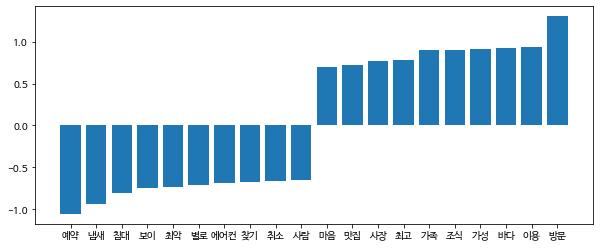

In [ ]:
plt.figure(figsize=(10, 4))
plt.rc('font', family="NanumBarunGothic")
plt.rcParams["axes.unicode_minus"] = False # 한글 폰트 사용시 - 깨지는 문제 해결

plt.bar(neg_top_word, neg_top_score, label = "부정", color = 'r')
plt.bar(pos_top_word, pos_top_score, label = "긍정", color = 'g')

plt.bar(range(len(top_score)), top_score)
plt.xticks(range(len(top_word)), top_word)
plt.show()


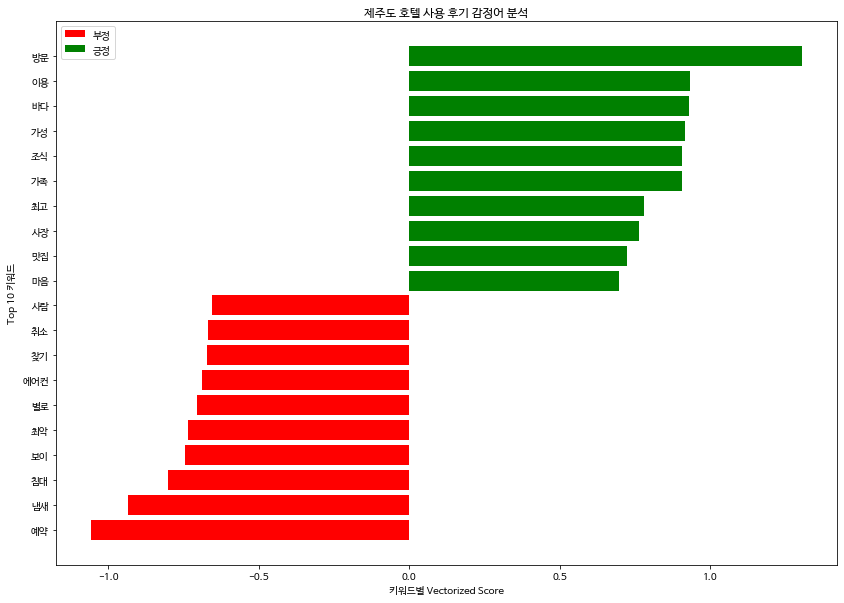

In [ ]:
# 감정분석 결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=[14, 10])
plt.barh(neg_top_word, neg_top_score, label = "부정", color = 'r')
plt.barh(pos_top_word, pos_top_score, label = "긍정", color = 'g')
plt.legend()
plt.xlabel('키워드별 Vectorized Score')
plt.ylabel('Top 10 키워드')
# Giving the tilte for the plot
plt.title('제주도 호텔 사용 후기 감정어 분석')
# Saving the plot as a 'png'
plt.savefig('2BarPlot.png')
# Displaying the bar plot
plt.show()

Text(0.5, 0.98, 'Categorical Plotting')

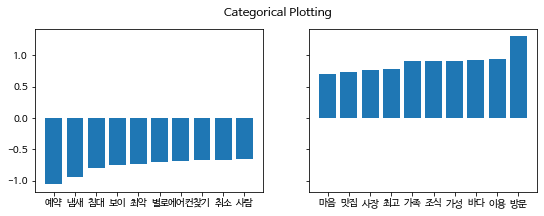

In [ ]:
# 약간 다르게 시각화
import matplotlib.pyplot as plt

data1 = {'apple': 10, 'orange': 15, 'lemon': 5, 'lime': 20}
names1 = list(data1.keys())
values1 = list(data1.values())

data2 = {'apple': 1, 'orange': 5, 'lemon': 15, 'lime': 25}
names2 = list(data2.keys())
values2 = list(data2.values())

fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].bar(neg_top_word, neg_top_score)
axs[1].bar(pos_top_word, pos_top_score)
fig.suptitle('Categorical Plotting')

# 4.딥러닝(LSTM)에 의한 감정분석

## 가.환경 변수 설정 및 데이터 탐색

패딩 : 이제 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

In [ ]:
!pip install sentencepiece

In [ ]:
# vocab loading
import sentencepiece as spm
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'kowiki', 'kowiki_32000.model'))

True

In [ ]:
# 구글드라이브 영화자료 불러와서 사용
df = pd.read_csv(os.path.join(data_dir, 'movie_comment.csv'), index_col=False)[['Score','Comment']]
df

,Score,Comment
0,1,대놓고 2편의 예고편....나중에 2편나올때 케이블에서 다시보면될정도...
1,6,난또 라스트제다이 스핀오프편인줄 알았네..ㅡㅡ
2,10,단순한 우주재난 영화가 아닌 '죽음과 삶'이라는 주제를 담고 있는 영화.. 최고의 ...
3,10,큰 기대 없이 지나가다가 TV에서 광고만 보고 재밌겠다 싶어서 봤는데 ㅋㅋㅋ 생각보...
4,10,'두려움은 마음을 죽인다. 두려움이 사라지면 나만 오롯이 남는다.' 이미 다음편이 ...
...,...,...
9985,2,디 오리지널은 개뿔 앞뒤 다 잘라놓고 오리지널? 오리지널 뜻 모르냐?
9986,10,보고나서도 입꼬리가 내려가질 않아요ㅎㅎ 건강한 코미디라는 말이 딱 맞는듯. 영화관에...
9987,10,소재가 독특한데 19금 유머와 함께여서 자칫 어두울 수 있는 현실이 웃음으로 잘 승...
9988,10,실화를 떠나 몰입할 수 밖에 없는 스토리.. 실감나는 배우들의 연기력.. 실화와 관...


In [ ]:
# document 길이 데이터
train_length = df["Comment"].astype("str").apply(lambda x:len(vocab.encode_as_pieces(x)))
train_length.head(10)

0    26
1    20
2    25
3    44
4    29
5    14
6    14
7    59
8    16
9    18
Name: Comment, dtype: int64

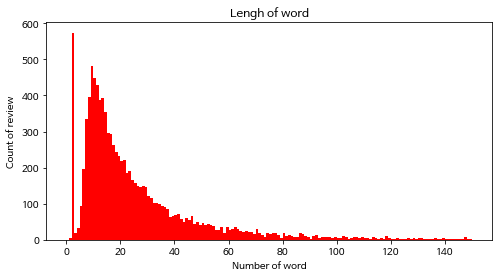

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=150, range=[0, 150], facecolor='r', label='word')
plt.title('Lengh of word')
plt.xlabel('Number of word')
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"token 길이 최대:    {np.max(train_length):4d}")
print(f"token 길이 최소:    {np.min(train_length):4d}")
print(f"token 길이 평균:    {np.mean(train_length):7.2f}")
print(f"token 길이 표준편차: {np.std(train_length):7.2f}")

token 길이 최대:     483
token 길이 최소:       1
token 길이 평균:      27.37
token 길이 표준편차:   33.08


In [ ]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"token 25/100분위:  {percentile25:7.2f}")
print(f"token 50/100분위:  {percentile50:7.2f}")
print(f"token 75/100분위:  {percentile75:7.2f}")
print(f"token IQR:        {percentileIQR:7.2f}")
print(f"token MAX/100분위: {percentileMAX:7.2f}")

token 25/100분위:    10.00
token 50/100분위:    17.00
token 75/100분위:    32.00
token IQR:          22.00
token MAX/100분위:   65.00


In [ ]:
# 앞으로 패딩입력을 위한 표준 최대 토큰수 졀정
n_seq = 65

In [ ]:
id_to_label = {0: "부정", 1: "긍정"}

In [ ]:
# 점수를 기준으로 긍정(4,5)과 부정(1-3)으로 변환
def rating_to_label(rating):
    if rating > 6:
        return 1
    else:
        return 0

df['y'] = df['Score'].apply(lambda x: rating_to_label(x))

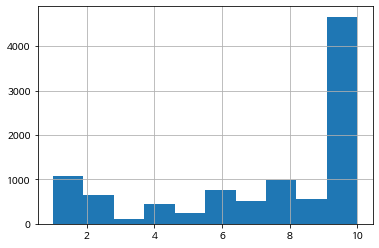

In [ ]:
# 점수별 빈도수
df['Score'].hist()

1    6715
0    3275
Name: y, dtype: int64


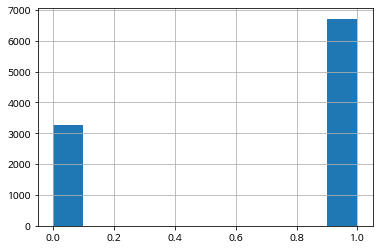

In [ ]:
# 점수별 빈도수
print(df['y'].value_counts())
df['y'].hist()

## 나.Train, Test 데이터 생성

### 방안1. 기존방법

In [ ]:
# 전체 데이터를 train 데이터 70%, test 데이터 30%로 분리
# 1 기존방법 df 적용,  2. undersampling으로 하면 new_df 입력
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df, test_size = 0.3, random_state=256) # 1방안
df_test = df_test.dropna()
df_test

,Score,Comment,y
8659,1,"전형적으로 초반, 중반, 후반이 따로 노는 영화",0
5725,4,그럭저럭. 1탄보다는 아쉽다.,0
1099,1,하 어라이벌 블레이드러너만 보고 바로 걸럿어야했는데 이걸 못 피했네..,0
8454,5,쿠키영상만 볼만함….,0
5444,1,연기력이 일단 바닥이고 연출력 스토리 뭐하나 제대로 된게 없는 아마추어 수준의 영화.,0
...,...,...,...
2979,9,우리가 영화를 사랑하는 이유 중 하나를 들려줬다.,1
7188,8,생각보다 뻔한 연출이다보니 오히려 배우들 연기력이 더 잘보이게된 케이스가 아닌가 싶...,1
6578,5,손에 땀을 쥐는 플롯이나 주제로 찰떡같이 귀결되는 연출 같은건 없다. 그냥 미국에사...,0
1914,10,그냥 너랑 봐서 좋았던 것 같다,1


### 방안 2.불균형문제 해결 Vs. 데이터 손실   

In [ ]:
# under-sampling 방법으로 불균형 해소 : 550개 샘플만 적용하여 학습 및 평가
positive_random_idx = df[df['y']==1].sample(3275, random_state=12).index.tolist()
negative_random_idx = df[df['y']==0].sample(3275, random_state=12).index.tolist()
random_idx = positive_random_idx + negative_random_idx
x = df['Comment'][random_idx]
y = df['y'][random_idx]
new_df = pd.concat([y,x],axis=1)
new_df

,y,Comment
3247,1,이해하면 굉장히 재미있는 영화!인간의 본질에 대해 생각하면 깨달음이 있고 나 자신도...
5508,1,전 개인적으론 재밌었어요. 솔직히 좀 지루함..ㅎㅎ
733,1,1초도 지루함이 없다. 미쳤다!
8148,1,NaN
6614,1,노회찬 의원님.. 그립습니다 대한민국 진보정치의 미래 이셨던분..
...,...,...
6381,0,쿠키영상을 보기위한 영화
4260,0,그냥 그랬음 칼질만 기억남
4594,0,<오징어게임>과 고교남자기숙사를 합하면?
5459,0,3년 전의 1편도 솔직히 별로였었지만 이번 2편은 역대 마블 영화들중 최악. 러닝 ...


In [ ]:
# 전체 데이터를 train 데이터 70%, test 데이터 30%로 분리
# 1 기존방법 df 적용,  2. undersampling으로 하면 new_df를 입력
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(new_df, test_size = 0.3, random_state=256) # 2방안

df_test = df_test.dropna()
df_test  # 550개중 165개 test용

,y,Comment
417,1,영상미 진짜 좋아요! 색감 최고~~다소 불편했던 장면들이 있었지만 시대상 반영이라고...
5522,0,톰 하디 혼자 한 영화.실패다 이번은 마블이 실패라니
4483,0,"스토리, 개연성, 새로 등장하는 캐릭터 컨셉 모두 폭망. 몇 년 만에 티켓값이 아까..."
4619,1,어머니와 함께 관람하며 깊은 숨과 가벼운 웃음의 시간을 보냈습니다. 노회찬 의원님에...
4118,0,제작진 또한 사춘기였네
...,...,...
1640,1,베놈의 팬이라면 만족하고 볼 수 있는정도
6842,1,최근 본 영화중에 가장 몰입도가 높았다장영남의 연기가 영화를 하드캐리하는 것처럼 보...
1033,0,중국자본의 할리우드 시도 그러나 실패명배우들을 이렇게 낭비시키기도 어려운 영화
2445,0,그나마 한때 노회찬을 좋아했던 추억으로 3점준다


### 공통적용

In [ ]:
# 1. 훈련용 데이터 정리
df_train = df_train.dropna()
df_train

,Score,Comment,y
4700,9,가볍게 보기좋은 코믹재난영화입니다,1
1904,8,와 대박 간만에 ㅎㅎ 푹빠져 봤습니다,1
1446,6,개연성이 너무 없더라~~~,0
5601,10,진짜 구라 1도안섞고 개재밌음 베놈 보고오니까 확실히 느껴진다 이건 수작이다.,1
4187,2,정말 고구마도 이런 고구마 영화가 없다. 정말 멘탈나가게하는 답답함의 연속인 영화,0
...,...,...,...
9523,10,베놈은 베놈이네 ㅋㅋㅋ 꼭 극장에서 보시길,1
1776,7,무난하다...,1
7233,7,1편보다 재미없다 액션도 그닥,1
423,2,영화시작한후 10분후 그냥… 잤다… OOO,0


In [ ]:
#3. n_seq 확인
n_seq

65

In [ ]:
# input 데이터와 라벨을 리턴해주는 함수 : 1. 입력변수 자료 데이터프레임, 2. 단어사전 vacab, 3. 토큰 최대입력 길이(패딩기준) n_seq
# 토큰의 최대입력길이 n_seq = percentile75 + percentileIQR(percentile75 -percentile25 ) * 1.5(즉, outlier만 제거하는 수준)
from tqdm.notebook import tqdm, trange

def make_data(df, vocab, n_seq):
    inputs, labels = [], []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        label = row["y"]
        document = row["Comment"]

        token = vocab.encode_as_ids(document)
        token = token[:n_seq]
        token = token + [0] * (n_seq - len(token))
        assert len(token) == n_seq
        # print(label, len(token), token)
        inputs.append(token)
        labels.append(label)
    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(df_train, vocab, n_seq)
train_inputs, train_labels

  0%|          | 0/6602 [00:00<?, ?it/s]

(array([[20219,  4569, 17851, ...,     0,     0,     0],
        [   10,    25,   235, ...,     0,     0,     0],
        [  760,   344,  1409, ...,     0,     0,     0],
        ...,
        [   36,   946,   319, ...,     0,     0,     0],
        [  284,    56,   919, ...,     0,     0,     0],
        [  311,    75,   427, ...,     0,     0,     0]]),
 array([1, 1, 0, ..., 1, 0, 0]))

In [ ]:
train_inputs.shape, train_labels.shape

((6602, 65), (6602,))

In [ ]:
test_inputs, test_labels = make_data(df_test, vocab, n_seq)
test_inputs, test_labels

  0%|          | 0/2830 [00:00<?, ?it/s]

(array([[ 5665,    27,  4391, ...,     0,     0,     0],
        [   34,  7130,   651, ...,     0,     0,     0],
        [  420,   540,  3491, ...,     0,     0,     0],
        ...,
        [ 6170, 24186,    11, ...,     0,     0,     0],
        [   34,  4906,  5331, ...,     0,     0,     0],
        [   72,    60,  1996, ...,     0,     0,     0]]),
 array([0, 0, 0, ..., 0, 1, 0]))

In [ ]:
test_inputs.shape, test_labels.shape

((2830, 65), (2830,))

## 다.Modeling

In [ ]:
import argparse
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args.n_out = 2
args

Namespace(d_model=256, n_out=2, n_vocab=32007, seed=1234)

In [ ]:
# 모델 정의
import tensorflow as tf

def build_model(args):
    inputs = tf.keras.layers.Input((None,))

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden = embedding(inputs)

    # modeling 선택 입력 부분 : RNN, CNN, Attention, Linear 등으로 입력
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True))
    hidden = lstm(hidden)
    #
    pool = tf.keras.layers.GlobalMaxPooling1D()
    hidden = pool(hidden)
    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(hidden)

    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model

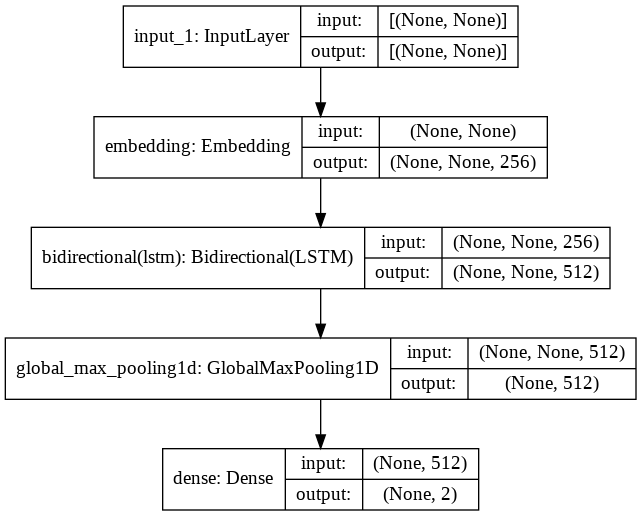

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict(train_inputs[:4])

array([[0.49497312, 0.5050269 ],
       [0.49354428, 0.5064558 ],
       [0.49563745, 0.5043626 ],
       [0.4953296 , 0.50467044]], dtype=float32)

In [ ]:
model.predict(test_inputs[:4])

array([[0.49504316, 0.50495684],
       [0.49304992, 0.5069501 ],
       [0.49700978, 0.50299025],
       [0.49358457, 0.5064155 ]], dtype=float32)

## 라.Train

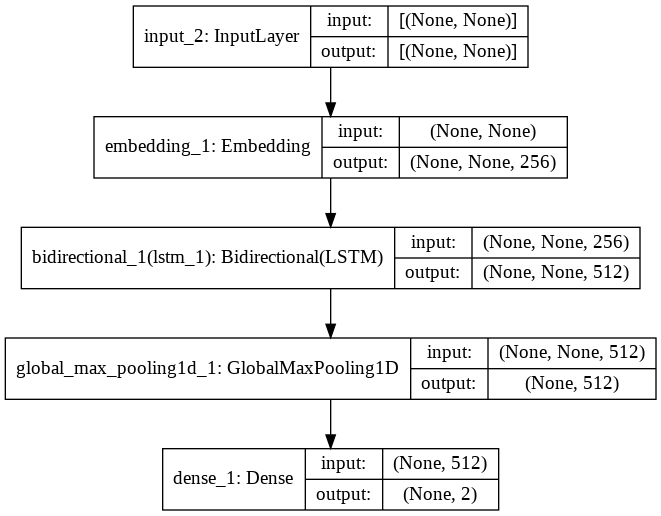

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(data_dir, 'myproject', "movie.hdf5"),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(data_dir,'myproject', "movie.csv"))

In [ ]:
history = model.fit(train_inputs, train_labels,
                    epochs=10,
                    batch_size=256,
                    validation_data=(test_inputs, test_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/10
26/26 [==============================] - 10s 185ms/step - loss: 0.6334 - accuracy: 0.6521 - val_loss: 0.5681 - val_accuracy: 0.7170

Epoch 00001: val_accuracy improved from -inf to 0.71696, saving model to /content/drive/MyDrive/Data/myproject/movie.hdf5
Epoch 2/10
26/26 [==============================] - 3s 125ms/step - loss: 0.4659 - accuracy: 0.7875 - val_loss: 0.4401 - val_accuracy: 0.7965

Epoch 00002: val_accuracy improved from 0.71696 to 0.79647, saving model to /content/drive/MyDrive/Data/myproject/movie.hdf5
Epoch 3/10
26/26 [==============================] - 3s 126ms/step - loss: 0.2744 - accuracy: 0.8872 - val_loss: 0.4676 - val_accuracy: 0.8000

Epoch 00003: val_accuracy improved from 0.79647 to 0.80000, saving model to /content/drive/MyDrive/Data/myproject/movie.hdf5
Epoch 4/10
26/26 [==============================] - 3s 125ms/step - loss: 0.1621 - accuracy: 0.9384 - val_loss: 0.6314 - val_accuracy: 0.7890

Epoch 00004: val_accuracy did not improve from 0.80000


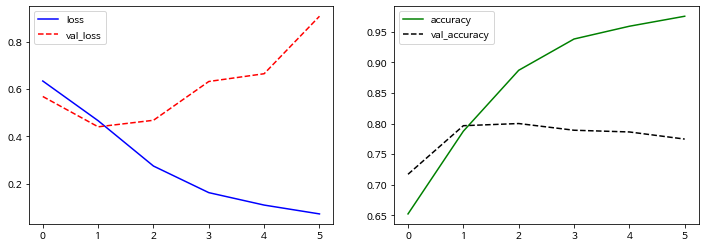

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.legend()

plt.show()

## 마.평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(data_dir,'myproject', "movie.hdf5"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate(test_inputs, test_labels)

89/89 [==============================] - 6s 18ms/step - loss: 0.4676 - accuracy: 0.8000


[0.46764376759529114, 0.800000011920929]

In [ ]:
y_pred = model.predict(test_inputs)
y_pred

array([[0.9224045 , 0.07759541],
       [0.7181757 , 0.28182435],
       [0.33665505, 0.663345  ],
       ...,
       [0.3836813 , 0.6163187 ],
       [0.31359234, 0.6864077 ],
       [0.01961307, 0.9803869 ]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

array([0, 0, 1, ..., 1, 1, 1])

In [ ]:
cf_matrix = np.zeros((2, 2)).astype(np.int)
cf_matrix

array([[0, 0],
       [0, 0]])

In [ ]:
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

array([[ 618,  353],
       [ 213, 1646]])

In [ ]:
tp = cf_matrix[1, 1]
tn = cf_matrix[0, 0]
fp = cf_matrix[0, 1]
fn = cf_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 0.1)
print(f'f1: {f1}')

accuracy: 0.8
precision: 0.8234117058529264
recall: 0.8854222700376546
f1: 0.8532918610679108


## 바.배포

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(data_dir,'myproject', "movie.hdf5"))

In [ ]:
string = "영화가 너무 심심해요"

In [ ]:
vocab.encode_as_pieces(string)

['▁영화', '가', '▁너무', '▁심', '심', '해', '요']

In [ ]:
infer_input = vocab.encode_as_ids(string)
infer_input = np.array([infer_input])
infer_input

array([[ 284,   19, 2360,  732,  690,   61,  489]])

In [ ]:
train_inputs.shape, infer_input.shape

((6602, 65), (1, 7))

In [ ]:
y_pred = model.predict(infer_input)
y_pred

array([[0.7810671 , 0.21893293]], dtype=float32)

In [ ]:
import numpy as np
y_class = np.argmax(y_pred, axis=-1)[0]
print(f"{string} : {id_to_label[y_class]}")

영화가 너무 심심해요 : 부정


In [ ]:
def do_predict(model, string):
    infer_input = vocab.encode_as_ids(string)
    infer_input = np.array([infer_input])

    y_pred = model.predict(infer_input)
    y_class = np.argmax(y_pred, axis=-1)[0]
    return id_to_label[y_class]

In [ ]:
do_predict(model, string)

'부정'

In [ ]:
while True:
    print("input> ", end="")
    string = str(input())
    if len(string) == 0:
        break
    result = do_predict(model, string)
    print(result)

input> 영화 너무 심심해요
부정
input> 배우들의 연기력이 좋아요
긍정
input> 스토리 전개가 뻔하다
부정
input> 영화가 전체적으로 지지 부진합니다.
긍정
input> 
